In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ak.to_list(ak.combinations([list(range(6))],2))

[[(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (1, 2),
  (1, 3),
  (1, 4),
  (1, 5),
  (2, 3),
  (2, 4),
  (2, 5),
  (3, 4),
  (3, 5),
  (4, 5)]]

In [3]:
def get_all_triH_njet_combs(njet=6):
    if njet < 6: return []
    
    jets = list(range(njet))
    j0 = jets[0]
    triH_combs = [ [j0,j1] for j1 in jets[1:] ]
    triH_combs = [ comb+[j2] for comb in triH_combs for j2 in jets if j2 not in comb]
    triH_combs = [ comb+[j3] for comb in triH_combs for j3 in jets if j3 not in comb and j3>comb[-1]]
    triH_combs = [ comb+[j4] for comb in triH_combs for j4 in jets if j4 not in comb and j4>comb[-2]]
    triH_combs = [ comb+[j5] for comb in triH_combs for j5 in jets if j5 not in comb and j5>comb[-1]]
    return triH_combs

In [65]:
triH_combs = get_all_triH_njet_combs()

In [5]:
triH_combs

[[0, 1, 2, 3, 4, 5],
 [0, 1, 2, 4, 3, 5],
 [0, 1, 2, 5, 3, 4],
 [0, 2, 1, 3, 4, 5],
 [0, 2, 1, 4, 3, 5],
 [0, 2, 1, 5, 3, 4],
 [0, 3, 1, 2, 4, 5],
 [0, 3, 1, 4, 2, 5],
 [0, 3, 1, 5, 2, 4],
 [0, 4, 1, 2, 3, 5],
 [0, 4, 1, 3, 2, 5],
 [0, 4, 1, 5, 2, 3],
 [0, 5, 1, 2, 3, 4],
 [0, 5, 1, 3, 2, 4],
 [0, 5, 1, 4, 2, 3]]

In [127]:
f_presel = "/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/NMSSM_cutflow_studies/presel/NMSSM_XYH_YToHH_6b_MX_700_MY_400_500k/ntuple.root"
tree = Signal(f_presel)

/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/NMSSM_cutflow_studies/presel/NMSSM_XYH_YToHH_6b_MX_700_MY_400_500k/ntuple.root


In [133]:
kin_dict = {
    'ptRegressed' : tree.jet_ptRegressed[sixb_events][tree.jet_signalId[sixb_events] == 0],
    'eta' : tree.jet_eta[sixb_events][tree.jet_signalId[sixb_events] == 0],
    'phi' : tree.jet_phi[sixb_events][tree.jet_signalId[sixb_events] == 0],
    'm' : tree.jet_m[sixb_events][tree.jet_signalId[sixb_events] == 0],
}

keys = ['ptRegressed', 'eta', 'phi', 'm']
def get_dict(i):
    return {
        'ptRegressed' : ak.flatten(tree.jet_ptRegressed[sixb_events][tree.jet_signalId[sixb_events] == i]),
        'eta' : ak.flatten(tree.jet_eta[sixb_events][tree.jet_signalId[sixb_events] == i]),
        'phi' : ak.flatten(tree.jet_phi[sixb_events][tree.jet_signalId[sixb_events] == i]),
        'm' : ak.flatten(tree.jet_m[sixb_events][tree.jet_signalId[sixb_events] == i]),
    }

In [134]:
HX_b1 = Particle(kin_dict=get_dict(0))
HX_b2 = Particle(kin_dict=get_dict(1))
H1_b1 = Particle(kin_dict=get_dict(2))
H1_b2 = Particle(kin_dict=get_dict(3))
H2_b1 = Particle(kin_dict=get_dict(4))
H2_b2 = Particle(kin_dict=get_dict(5))

In [135]:
HX_b1.pt, HX_b2.pt

(<Array [135, 142, 131, 100, ... 129, 133, 98.8] type='88786 * float32'>,
 <Array [40.4, 72.9, 44.5, ... 55.8, 45.6, 61.2] type='88786 * float32'>)

In [136]:
HX = HX_b1 + HX_b2
H1 = H1_b1 + H1_b2
H2 = H2_b1 + H2_b2
HX.m

<Array [114, 128, 130, ... 91.7, 140, 151] type='88786 * float32'>

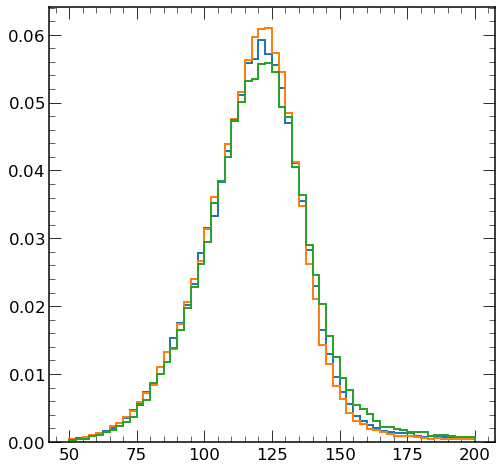

In [137]:
fig, ax = plt.subplots()

n = Hist(HX.m, bins=np.linspace(50,200,61), ax=ax)
n = Hist(H1.m, bins=np.linspace(50,200,61), ax=ax)
n = Hist(H2.m, bins=np.linspace(50,200,61), ax=ax)

In [131]:
sixb_events = ak.sum(tree.jet_signalId > -1, axis=1) == 6
ak.any(tree.n_jet[sixb_events] < 6)

False

In [132]:
triH_tru = ak.argsort(tree.jet_signalId,axis=-1)[sixb_events]
triH_tru

<Array [[5, 7, 1, 6, 0, 2, ... 4, 0, 2, 3, 5]] type='88786 * var * int64'>

In [138]:
def pair_adjacent_jets(pt,eta,phi,m):
    j0,j1,j2,j3,j4,j5 = [ vector.obj(pt=pt[:,ijet],eta=eta[:,ijet],phi=phi[:,ijet],m=m[:,ijet]) for ijet in range(6) ]
    
    h0 = HX
    h1 = H1
    h2 = H2
    # h0 = j0+j1
    # h1 = j2+j3
    # h2 = j4+j5
    
    h_pt,h_eta,h_phi,h_m = [ ak.concatenate([getattr(h,kin)[:,np.newaxis] for h in [h0,h1,h2]],axis=-1) for kin in ('pt','eta','phi','m') ]

    pt_sorted = ak.argsort(h_pt,ascending=False)
    
    h_pt,h_eta,h_phi,h_m = [ h_kin[pt_sorted] for h_kin in [h_pt,h_eta,h_phi,h_m] ]
    
    h0,h1,h2 = [ vector.obj(pt=h_pt[:,ih],eta=h_eta[:,ih],phi=h_phi[:,ih],m=h_m[:,ih]) for ih in range(3) ]
    
    return h0,h1,h2

In [139]:
def use_triH_comb(tree,triH_comb,sixb_events):
    if type(triH_comb) == list:
        triH_comb = ak.Array([triH_comb]*ak.sum(sixb_events))
    pt =  tree.jet_pt[sixb_events][triH_comb]
    eta = tree.jet_eta[sixb_events][triH_comb]
    phi = tree.jet_phi[sixb_events][triH_comb]
    m = tree.jet_m[sixb_events][triH_comb]
    return pair_adjacent_jets(pt,eta,phi,m)

In [140]:
def get_m_vec(tree,triH_comb,sixb_events):
    h0,h1,h2 = use_triH_comb(tree,triH_comb,sixb_events)
    m0,m1,m2 = h0.m,h1.m,h2.m
    m_vec = vector.obj(x=m0,y=m1,z=m2)
    return m_vec

In [144]:
def higgs_performance(x,y,z,saveas=None):
    bins = np.linspace(25,300,61)

    fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(18,5), constrained_layout=True)

    n = Hist(x, bins=bins, ax=axs[0], label='x')
    n = Hist(y, bins=bins, ax=axs[0], label='y')
    n = Hist(z, bins=bins, ax=axs[0], label='z')
    axs[0].set_xlabel(r"Reco $M_H$ [GeV]")

    n, ex, ey, im = Hist2d(x, y, bins=bins, ax=axs[1])
    axs[1].set_xlabel(r"Reco $M_{H,x}$ [GeV]")
    axs[1].set_ylabel(r"Reco $M_{H,y}$ [GeV]")
    fig.colorbar(im, ax=axs[1])

    n, ex, ey, im = Hist2d(x, z, bins=bins, ax=axs[2])
    axs[1].set_xlabel(r"Reco $M_{H,x}$ [GeV]")
    axs[1].set_ylabel(r"Reco $M_{H,z}$ [GeV]")
    # hist_multi([x,y,z],labels=["Mx","My","Mz"],xlabel="Dijet M",figax=(fig,axs[0])); hist2d_simple(x,y,xlabel="Mx",ylabel="My",figax=(fig,axs[1])); hist2d_simple(x,y,xlabel="Mx",ylabel="Mz",figax=(fig,axs[2]));
    # if saveas: save_fig(fig,"d_hhh",saveas)

In [145]:
m_vec = get_m_vec(tree,triH_tru,sixb_events)
x,y,z = [ak.to_numpy(r) for r in (m_vec.x,m_vec.y,m_vec.z)]

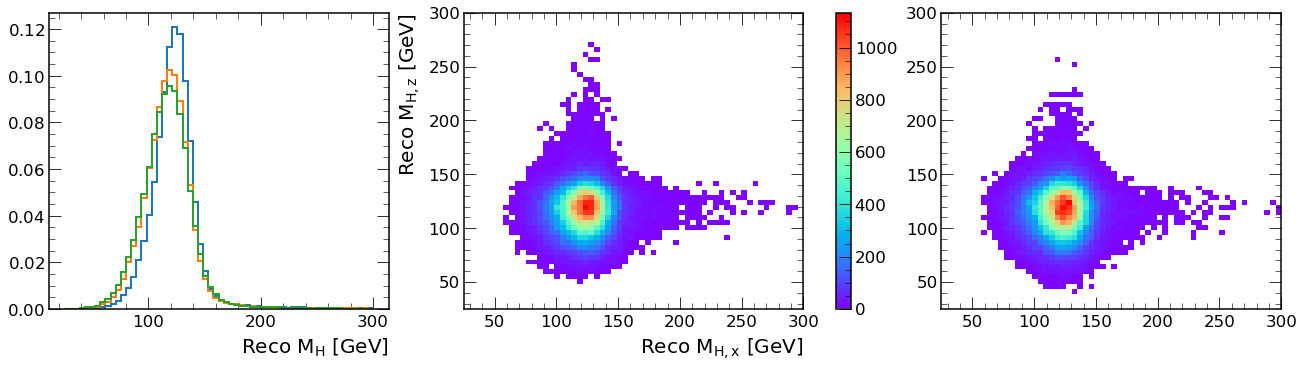

In [143]:
higgs_performance(x,y,z,"input_points")

In [146]:
r_vec = lambda phi,theta : vector.obj(rho=1,phi=phi,theta=theta)
d_hhh_inv = lambda angles : -1/ak.mean(m_vec.cross(r_vec(angles[0],angles[1])).mag,axis=-1)
x_min = scipy.optimize.fmin(d_hhh_inv,[np.pi/4,np.pi/2])

Optimization terminated successfully.
         Current function value: -0.030027
         Iterations: 34
         Function evaluations: 67


In [147]:
mean_phi,mean_theta = x_min
print(mean_phi,mean_theta)

0.7635184136796923 0.9819135226023834


In [ ]:
r_vec = lambda phi,theta : vector.obj(rho=1,phi=phi,theta=theta)
d_hhh_inv = lambda angles : -1/ak.mean(m_vec.cross(r_vec(angles[0],angles[1])).mag,axis=-1)
x_min = scipy.optimize.fmin(d_hhh_inv,[np.pi/4,np.pi/2])

Optimization terminated successfully.
         Current function value: -0.032480
         Iterations: 29
         Function evaluations: 64


In [15]:
mean_phi,mean_theta = x_min
print(mean_phi,mean_theta)

0.7661090402653312 0.9773878735143617


In [148]:
f_test = "/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/NMSSM_cutflow_studies/presel/NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root"

In [161]:
tree_test = Signal(f_test)
mask = ak.local_index(tree_test.n_jet) > -1

/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/NMSSM_cutflow_studies/presel/NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root


In [166]:
def find_triH_sys(selection,phi=mean_phi,theta=mean_theta):
    r_vec = vector.obj(rho=1,phi=phi,theta=theta)
    triH_m_combs = [ get_m_vec(selection,triH_comb,mask) for triH_comb in triH_combs ]

    triH_m_combs_d = np.array([ triH_m.cross(r_vec).mag for triH_m in triH_m_combs ]).T

    best_triH_comb_id = np.argmin(triH_m_combs_d,axis=-1)
    best_triH_comb = ak.broadcast_arrays(np.array(triH_combs)[best_triH_comb_id],selection.jet_ptRegressed[:,:6])[0]

    best_triH_m = get_m_vec(selection,best_triH_comb)
    selection.extend(H_m=ak.concatenate( [m[:,np.newaxis] for m in [best_triH_m.x,best_triH_m.y,best_triH_m.z]],axis=-1) )
    return best_triH_m.x,best_triH_m.y,best_triH_m.z

In [167]:
tx,ty,tz = find_triH_sys(tree_test)

ValueError: cannot broadcast RegularArray of size 55952 with RegularArray of size 88786

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/awkward/_util.py#L914)

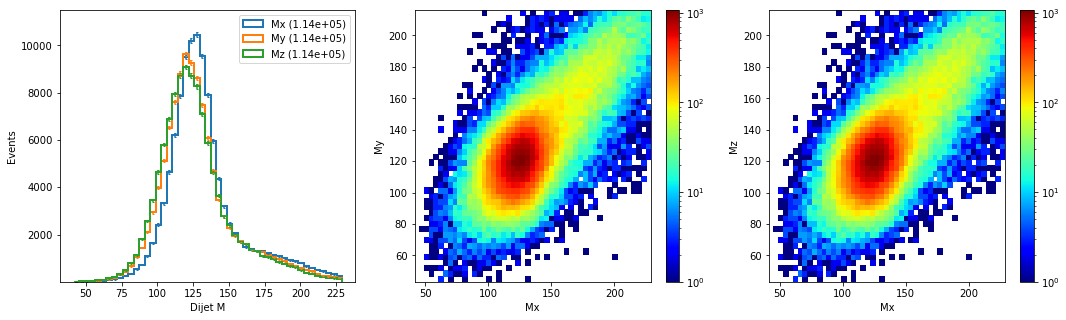

In [ ]:
higgs_performance(tx,ty,tz,"output_points")

In [19]:
selection_full = Selection(tree,njets=6)

In [20]:
tx,ty,tz = find_triH_sys(selection)

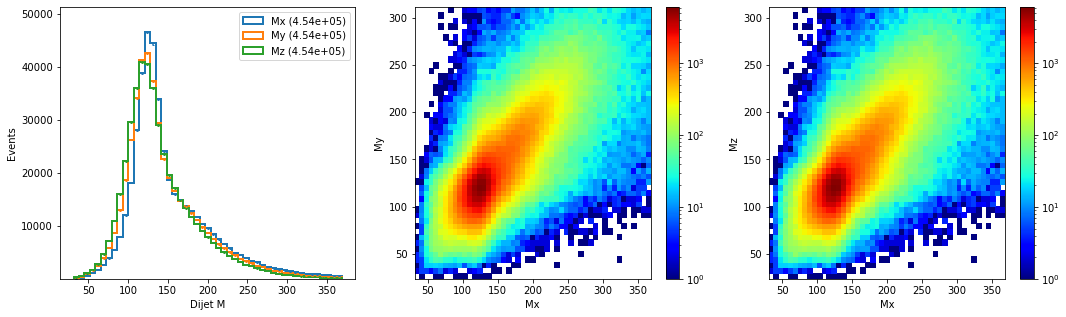

In [21]:
higgs_performance(tx,ty,tz,"output_points")

In [22]:
qcd_tree = Tree(fc.sr.QCD_B_List)

In [23]:
tx,ty,tz = find_triH_sys(qcd_tree)

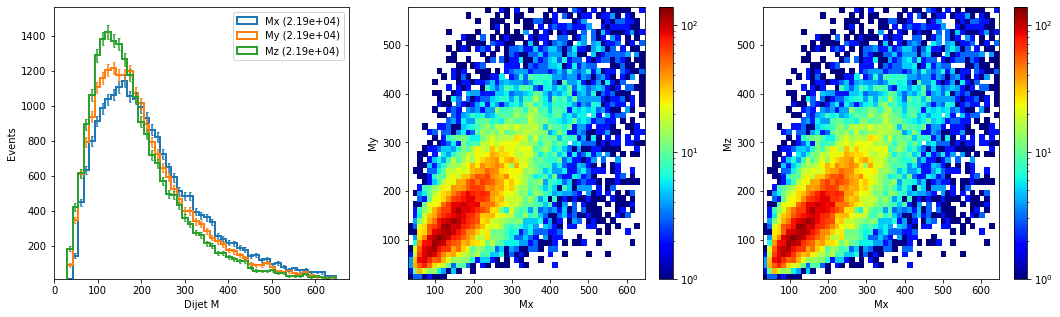

In [24]:
higgs_performance(tx,ty,tz,"qcd_points")